# Исходные данные

In [1]:
from scipy.integrate import odeint
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy import pi, sin
import warnings as w

w.filterwarnings("ignore")

# Давления в каналах
p1 = 400e3
p2_0 = 300e3
p3 = 100e3

# Параметры демпфирующей жидкости
Vд_0 = 0
mд_0 = 0

# Параметры жидкости -> керосин
c = 1330
Vж0 = 0.004
ρж = 820

# Параметры газа -> гелий
k = 1.4
R = 8.314
M = 0.0040026
R_газ = R / M
Tгаз_0 = 293
Vгаз_0 = 0.003

# Коэффициенты инерционности
j1 = j2 = j3 = 400
jд = 20

# Коэффициенты сопротивления
ξ1 = ξ2 = ξ3 = 1000
ξд = 1000

# Решение стационарной задачи

In [2]:
def system_static(vars):
    """ Система уравнений стационарной системы """
    m1_0, m2_0, m3_0, p4_0, pgas_0 = vars
    
    return [m1_0 + m2_0 - m3_0,
            p4_0 - pgas_0,
            p1 - p4_0 - ξ1*m1_0**2,
            p4_0 - p3 - ξ3*m3_0**2,
            p2_0 - p4_0 - ξ2*m2_0**2]


# Вводим начальные приближения
initial_guess = [5, 5, 5, 3e5, 3e5]

# Решение системы
sol_static = fsolve(system_static, initial_guess)

m1_0 = sol_static[0]
m2_0 = sol_static[1]
m3_0 = sol_static[2]
p4_0 = sol_static[3]
pgas_0 = sol_static[4]

rho_газ = pgas_0 / (R_газ * Tгаз_0)
m_газ = rho_газ * Vгаз_0

# Вывод переменных
print("  m1_0 = {:.3f}".format(m1_0))
print("  m2_0 = {:.3f}".format(m2_0))
print("  m3_0 = {:.3f}".format(m3_0))
print("  p4_0 = {:.3f}".format(p4_0))
print("pgas_0 = {:.3f}".format(pgas_0))
print("  m_газ = {:.3f}".format(m_газ))

  m1_0 = 10.515
  m2_0 = 3.249
  m3_0 = 13.764
  p4_0 = 289442.719
pgas_0 = 289442.719
  m_газ = 0.001


# Дополнительные функции и константы

In [3]:
# Функции возмущения
def p2(t):
    """ Функция импульсного возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


def p2_sin(t):
    """ Функция возмущения, изменяющаяся по синусу """
    z = 2 * t * pi/T
    insin = z - pi/2
    p2 = p2_0 + A*sin(insin)
    return p2


def p2_sin_afc(t, freq):
    """ Функция возмущения, зависящая от частоты """
    insin = freq * 2*pi * t 
    p2 = p2_0 + A*sin(insin)
    return p2


# Функция построения графиков
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("$t, с$")
    plt.ylabel(label)
    plt.legend()
    plt.show()


A = 1000  # Амплитуда возмущения
T = 0.1  # Период возмущения

# Временной отрезок моделирования
t_end = .8
h = 1e-6
t = np.arange(0, t_end, h)

# Наборы начальных значений
y0 = [p4_0, Vд_0, m1_0, m2_0, m3_0, mд_0]
y0_n_d = [p4_0, m1_0, m2_0, m3_0]

# Частотный диапазон
frequancy = []
for freq in np.arange(0, 16, 1):
    frequancy.append(freq)
for freq in np.arange(20, 105, 5):
    frequancy.append(freq)
for freq in np.arange(125, 1025, 25):
    frequancy.append(freq)

# Решение динамической задачи с демпфером

## Решение СДУ

In [4]:
def system(y, t):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (m_газ / (Vгаз_0 - Vд)) * R_газ * 
            (Tгаз_0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


# Решение
sol = odeint(system, y0, t)

p_газ = (m_газ / (Vгаз_0 - sol[:, 1])) * R_газ * \
    (Tгаз_0 * ((sol[:, 0] / p4_0)**((k-1)/k)))

In [5]:
max(sol[:, 0])

290168.46072441916

## Построение графиков

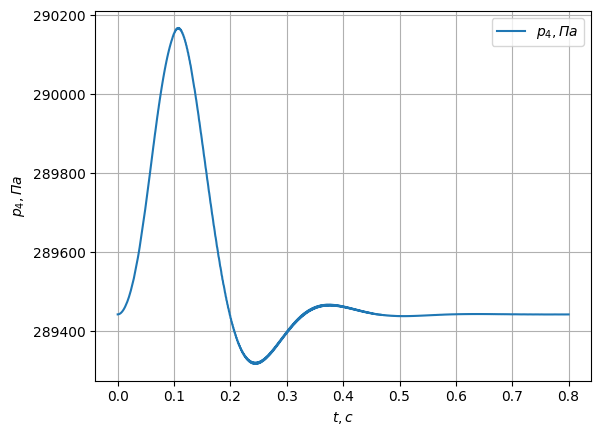

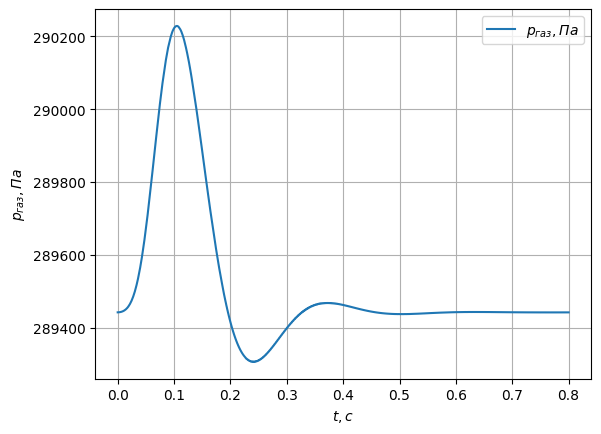

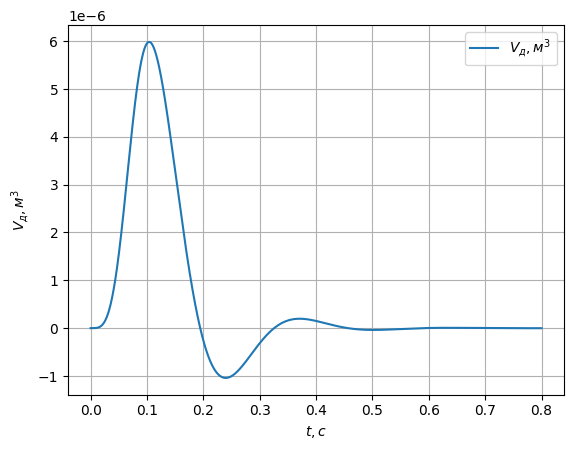

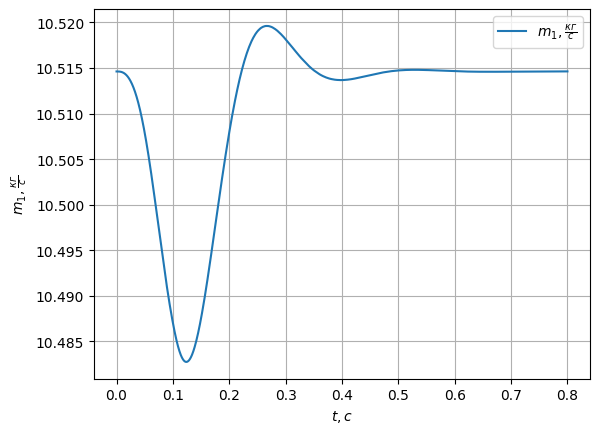

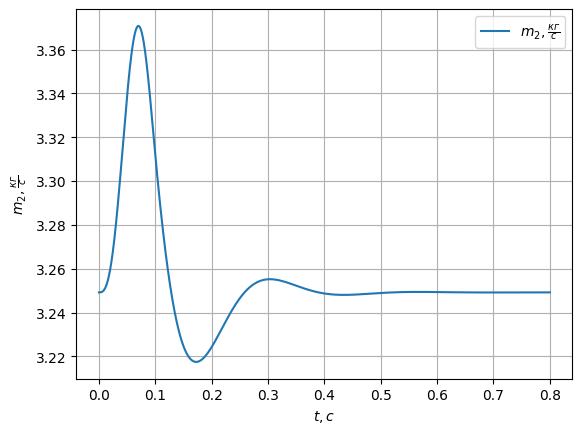

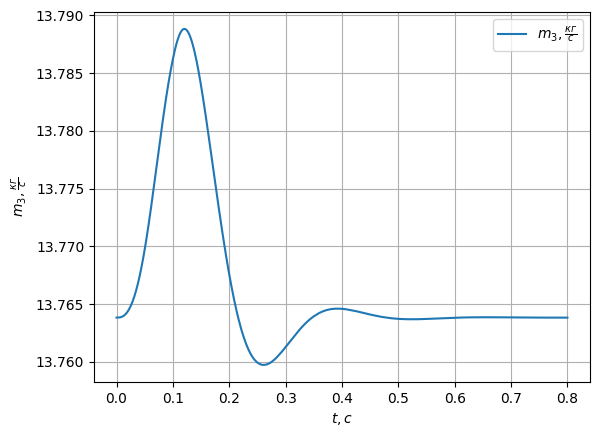

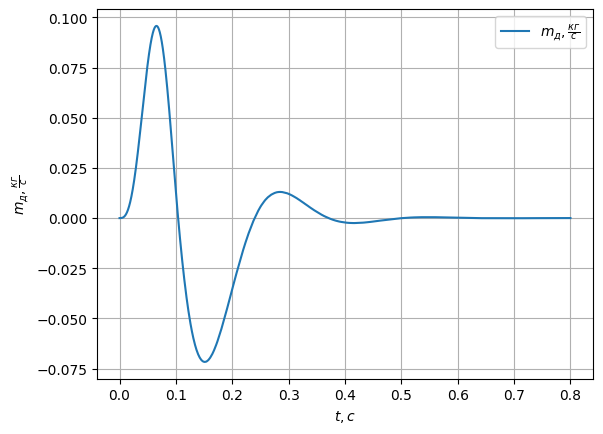

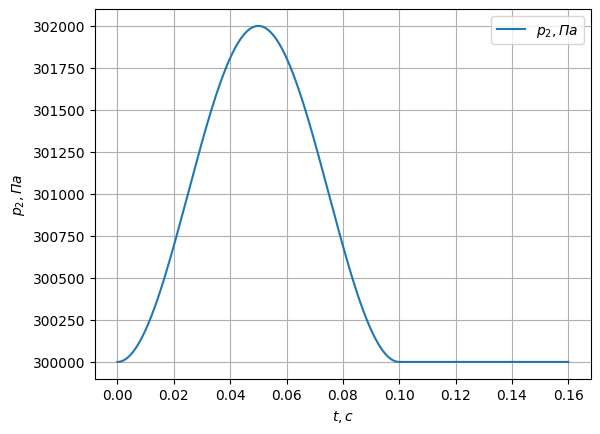

In [6]:
plot(t, sol[:, 0], r"$p_4, Па$")
plot(t, p_газ, r"$p_{газ}, Па$")
plot(t, sol[:, 1], r"$V_д, м^3$")
plot(t, sol[:, 2], r"$m_1, \frac{кг}{с}$")
plot(t, sol[:, 3], r"$m_2, \frac{кг}{с}$")
plot(t, sol[:, 4], r"$m_3, \frac{кг}{с}$")
plot(t, sol[:, 5], r"$m_д, \frac{кг}{с}$")
plot(t[:int(t_end//h//5)], [p2(t) for t in t][:int(t_end//h//5)], "$p_2, Па$")

# Построение АЧХ системы с демпфером

## Решение

In [10]:
def system_afc(y, t, freq):
    """ Система дифференциальных уравнений, зависящая от частоты """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2_sin_afc(t, freq) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (m_газ / (Vгаз_0 - Vд)) * R_газ * 
            (Tгаз_0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


sol_afc = []
amplitude = []
for freq in frequancy:
    sol_afc = odeint(system_afc, y0, t, (freq,))
    amplitude.append(
        (max(sol_afc[700000:800000, 0]) - 
         min(sol_afc[700000:800000, 0])) / 2 / A)
    del sol_afc

print(amplitude)

[1.3026874512434006e-10, 0.055803837309620574, 0.3377616217574105, 0.47503589404060037, 0.21991106737570953, 0.40310645221965385, 0.2515213312741544, 0.16333590511846705, 0.10526699956710217, 0.06448962849244708, 0.03708559103804873, 0.017881203068391187, 0.004083427628560458, 0.009607956760039088, 0.01753821127847186, 0.023651333488494856, 0.04077905170194572, 0.04806035282154335, 0.05169574103935156, 0.05397801102188532, 0.055415325006237255, 0.05645923408694216, 0.05710259116551606, 0.057808917236543494, 0.05822920361807337, 0.05863921474746894, 0.058787963391951054, 0.05920642566127936, 0.059562304715276695, 0.059743391280149806, 0.06002288322849199, 0.06019086179614533, 0.060405440300819464, 0.061384689583122966, 0.06251994803218985, 0.06375674903407344, 0.06524975777580402, 0.06688355295127257, 0.06875486547741456, 0.07082361151778604, 0.07332077329393359, 0.07603503050742438, 0.07913137994045974, 0.08358664339932148, 0.08863949349347967, 0.09468917043716647, 0.10242077433041413,

## График АЧХ

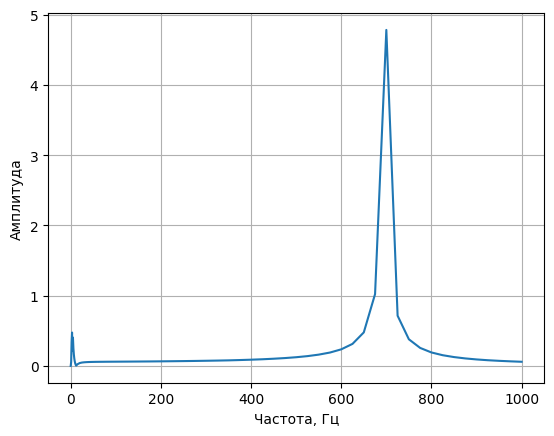

In [11]:
plt.plot(frequancy, amplitude)
plt.grid()
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.show()

# Решение динамической задачи без демпфера

## Решение СДУ

In [ ]:
def system_no_damper(y, t):
    """ Система дифференциальных уравнений """
    p4, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3) / ((Vж0) / c**2)
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_m1, d_m2, d_m3]


def p2(t):
    """ Функция возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


sol_no_damper = odeint(system_no_damper, y0_n_d, t)

In [ ]:
max(sol_no_damper[:, 0])

290457.7579556309

## Построение графиков

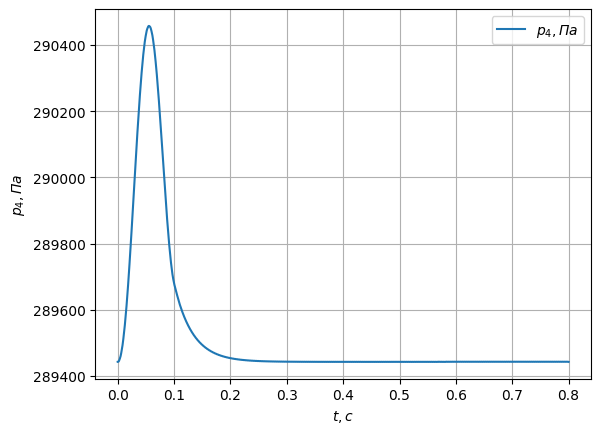

In [ ]:
plot(t, sol_no_damper[:, 0], r"$p_4, Па$")
# plot(t, sol_no_damper[:, 1], r"$m_1, \frac{кг}{с}$")
# plot(t, sol_no_damper[:, 2], r"$m_2, \frac{кг}{с}$")
# plot(t, sol_no_damper[:, 3], r"$m_3, \frac{кг}{с}$")

# Построение АЧХ системы без демпфера

## Решение

In [12]:
def system_afc_no_damper(y, t, freq):
    """ Система дифференциальных уравнений """
    p4, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3) / ((Vж0) / c**2)
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2_sin_afc(t, freq) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_m1, d_m2, d_m3]


sol_afc_no_damper = []
amplitude_nodamper = []
for freq in frequancy:
    sol_afc_no_damper = odeint(system_afc_no_damper, y0_n_d, t, (freq,))
    amplitude_nodamper.append(
        (max(sol_afc_no_damper[700000:800000, 0]) - 
         min(sol_afc_no_damper[700000:800000, 0])) / 2 / A) 
    del sol_afc_no_damper

print(amplitude_nodamper)

[2.9103830456733704e-14, 0.02690161683081533, 0.35378634430730016, 0.18013147069636035, 0.49705908872929283, 0.3345301426340593, 0.48571884442516605, 0.4197665742102545, 0.4440918878347147, 0.42860672330672966, 0.41583619967201957, 0.4053694441241678, 0.39664847124327207, 0.38944461232959293, 0.382881966701214, 0.3779525202126242, 0.3618212242500158, 0.3538188302536146, 0.3497312705740624, 0.34791532757546517, 0.3473809853059356, 0.3476634615317162, 0.34859018038836076, 0.35009019647943207, 0.3517304933388659, 0.353982045071316, 0.3565689629435947, 0.3595380640928634, 0.36285559793686845, 0.3665248804507428, 0.37055489488766763, 0.37495830733678304, 0.379751982160582, 0.4104549128526414, 0.4559890566066897, 0.5251225125492492, 0.6366881679183279, 0.8386443428539205, 1.2985537446272792, 3.252833926642925, 4.3863212271934895, 1.2877753524189466, 0.726069737656886, 0.49414459977453223, 0.3684146251886559, 0.28979030098803926, 0.23628001759733888, 0.19771690971887437, 0.1687345827393874, 0

## График АЧХ

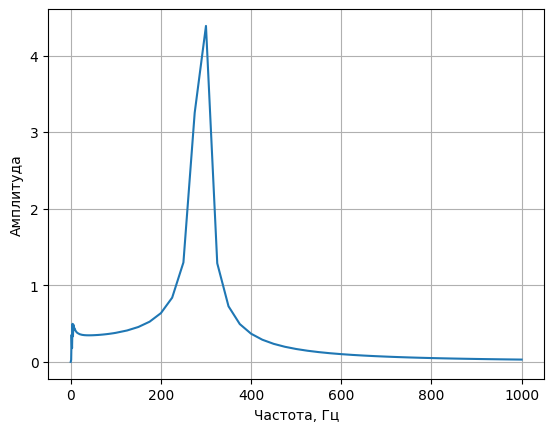

In [13]:
plt.plot(frequancy, amplitude_nodamper)
plt.grid()
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.show()